
### LLC4320 : Comparison Eulerian and Lagrangian basics statistics (mean velocity fields)

In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5164588.datarmor0/parcels-502090/libparcels_random_5e277942-50a2-4923-8170-94db45423658.so


In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster() #processes=7, cores=7
#w = cluster.scale(jobs=3)
#
client = Client(cluster)



In [3]:
client

Client Scheduler: tcp://127.0.0.1:33919 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 100.00 GiB


### Load data

In [4]:
# Lagrangian data
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [5]:
ds_Lstats = p.load_diagnostic('L_dl1.0_stats.zarr')
ds_Lstats = ds_Lstats.compute()

In [6]:
ds_Lstats

<xarray.Dataset>
Dimensions:                            (lat: 179, lon: 359)
Coordinates:
  * lat                                (lat) float64 -89.5 -88.5 ... 87.5 88.5
  * lon                                (lon) float64 -179.5 -178.5 ... 178.5
Data variables: (12/30)
    EKE                                (lon, lat) float64 nan nan ... nan nan
    EKE_binned                         (lon, lat) float64 nan nan ... nan nan
    EKE_ibinned                        (lon, lat) float64 nan nan ... nan nan
    KE                                 (lon, lat) float64 nan nan ... nan nan
    mean_KE                            (lon, lat) float64 nan nan ... nan nan
    mean_KE_binned                     (lon, lat) float64 nan nan ... nan nan
    ...                                 ...
    zonal_velocity_binned_iprime       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_square              (lon, lat) float64 nan nan ... nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

In [7]:
def read_Ediag(V,diags):
    ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in diags])

    grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
    ds = xr.merge([ds,grid])
    #ds = ds#.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
    ds['lon'] = 0*ds.face+ds.XC
    ds['lat'] = 0*ds.face+ds.YC
    ds = ds.compute()
    # Rotation velocity field
    for diag in diags:
        ds['zonal_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.CS - ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.SN
        ds['meridional_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.SN + ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.CS

        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
 #   ds = llcreader.faces_dataset_to_latlon(ds)
    return ds

In [8]:
# Eulerian data
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean",'mean_square',"prime_mean_sq"]#, "prime_mean","prime_mean_sq"]
ds = read_Ediag(V,D)

In [17]:
ds = ds.drop(['mean_SSU','mean_SSV','mean_square_SSU','mean_square_SSV','prime_mean_sq_SSU','prime_mean_sq_SSV'])
ds

<xarray.Dataset>
Dimensions:                            (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates: (12/20)
  * face                               (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g                                (i_g) int64 0 1 2 3 ... 4317 4318 4319
  * j                                  (j) int64 0 1 2 3 ... 4316 4317 4318 4319
  * i                                  (i) int64 0 1 2 3 ... 4316 4317 4318 4319
  * j_g                                (j_g) int64 0 1 2 3 ... 4317 4318 4319
    CS                                 (face, j, i) float32 0.0 0.0 ... 0.0 0.0
    ...                                 ...
    dyC                                (face, j_g, i) float32 239.5 ... 324.6
    dyG                                (face, j, i_g) float32 479.0 ... 324.6
    rA                                 (face, j, i) float32 1.555e+05 ... 1.5...
    rAs                                (face, j_g, i) float32 7.774e+04 ... 1...
    rAw                                (face, j, i_g) float32 1.555e+05 ... 1...
    rAz                                (face, j_g, i_g) float32 7.774e+04 ......
Data variables:
    lon                                (face, j, i) float64 -114.9 ... -114.9
    lat                                (face, j, i) float64 -88.18 ... -88.17
    zonal_velocity_mean                (face, j, i) float32 nan nan ... nan nan
    meridional_velocity_mean           (face, j, i) float32 nan nan ... nan nan
    zonal_velocity_mean_square         (face, j, i) float32 nan nan ... nan nan
    meridional_velocity_mean_square    (face, j, i) float32 nan nan ... nan nan
    zonal_velocity_prime_mean_sq       (face, j, i) float32 nan nan ... nan nan
    meridional_velocity_prime_mean_sq  (face, j, i) float32 nan nan ... nan nan

In [8]:
def face2rec(ds,V):

    ds_rec = llcreader.faces_dataset_to_latlon(ds)
    dl = 1.
    lon = np.arange(-180.,180., dl)
    lat = np.arange(-90., 90., dl)
    _ds = ds_rec[V]
    _ds['lon'] = ds_rec.lon
    _ds['mean'] = _ds.groupby_bins('lon',bins=lon)
    return _ds

In [19]:
ds = ds.drop(['mean_SSU','mean_SSV','prime_mean_SSU','prime_mean_SSV','prime_mean_sq_SSU','prime_mean_sq_SSV'])

In [10]:
ds

<xarray.Dataset>
Dimensions:                             (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates: (12/20)
  * face                                (face) int64 0 1 2 3 4 ... 8 9 10 11 12
  * i_g                                 (i_g) int64 0 1 2 3 ... 4317 4318 4319
  * j                                   (j) int64 0 1 2 3 ... 4317 4318 4319
  * i                                   (i) int64 0 1 2 3 ... 4317 4318 4319
  * j_g                                 (j_g) int64 0 1 2 3 ... 4317 4318 4319
    CS                                  (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    ...                                  ...
    dyC                                 (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG                                 (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA                                  (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs                                 (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw                                 (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz                                 (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    lon                                 (face, j, i) float64 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    lat                                 (face, j, i) float64 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    zonal_velocity_mean                 (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    merirdional_velocity_mean           (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    zonal_velocity_prime_mean           (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    merirdional_velocity_prime_mean     (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    zonal_velocity_prime_mean_sq        (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    merirdional_velocity_prime_mean_sq  (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [11]:
_ds = face2rec(ds,'zonal_velocity_mean')

KeyboardInterrupt: 

In [13]:
_ds = _ds.persist()

In [15]:
_ds_mean = _ds.zonal_velocity_mean.compute()

In [ ]:
_ds_mean['lon'] = ds.lon.compute()
_ds_mean['lat'] = ds.lat.compute()

In [11]:
# Binning the Eulerian mean field (to compare with Lagrangian binned statisitcs)

dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-90., 90., dl)

#N = histogram(ds_mean.lon, ds_mean.lat, bins=[lon, lat], dim=['i', 'j', 'face'], block_size=None)

In [18]:
_ds

<xarray.Dataset>
Dimensions:            (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960)
Coordinates: (12/20)
  * face               (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g                (i_g) int64 0 1 2 3 4 5 ... 17275 17276 17277 17278 17279
  * j                  (j) int64 0 1 2 3 4 5 ... 12955 12956 12957 12958 12959
  * i                  (i) int64 0 1 2 3 4 5 ... 17275 17276 17277 17278 17279
  * j_g                (j_g) int64 0 1 2 3 4 5 ... 12955 12956 12957 12958 12959
    CS                 (j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                 ...
    rAw                (j, i_g) float32 1.555e+05 1.555e+05 ... 5.677e+03
    rAz                (j_g, i_g) float32 7.774e+04 7.775e+04 ... 8.727e+03
    dxC                (j, i_g) float32 324.6 324.6 324.6 ... 142.3 124.2 99.9
    dyC                (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyG                (j, i_g) float32 479.0 479.0 479.0 ... 123.7 108.2 87.37
    dxG                (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
Data variables:
    mean_SSU           (j, i_g) float32 nan nan nan nan nan ... nan nan nan nan
    prime_mean_SSU     (j, i_g) float32 nan nan nan nan nan ... nan nan nan nan
    prime_mean_sq_SSU  (j, i_g) float32 nan nan nan nan nan ... nan nan nan nan
    mean_SSV           (j_g, i) float32 nan nan nan nan nan ... nan nan nan nan
    prime_mean_SSV     (j_g, i) float32 nan nan nan nan nan ... nan nan nan nan
    prime_mean_sq_SSV  (j_g, i) float32 nan nan nan nan nan ... nan nan nan nan
    lon                (j, i) float64 -114.9 -114.9 -114.9 ... -38.0 -38.0
    lat                (j, i) float64 -88.18 -88.18 -88.18 ... 67.5 67.5 67.5

In [20]:
_ds.mean_SSU

<xarray.DataArray 'mean_SSU' (j: 12960, i_g: 17280)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    rAw      (j, i_g) float32 1.555e+05 1.555e+05 ... 1.141e+04 5.677e+03
    dxC      (j, i_g) float32 324.6 324.6 324.6 324.6 ... 156.9 142.3 124.2 99.9
    dyG      (j, i_g) float32 479.0 479.0 479.0 479.0 ... 123.7 108.2 87.37

In [ ]:
_ds_mean = _ds.groupby_bins('lon',bins=lon).mean()

In [10]:
ds_mean['mean_velocity_amplitude'] = np.sqrt(ds_mean.zonal_velocity_mean**2+ds_mean.meridional_velocity_mean**2)

In [28]:
U =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.CS - ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.SN
V =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.SN + ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.CS



In [15]:
_ds = ds_mean.zonal_velocity_mean

In [11]:
_ds = xr.Dataset({'U':ds_mean.zonal_velocity_prime_mean_sq,'V':ds_mean.meridional_velocity_prime_mean_sq})

In [12]:
simple_ds = llcreader.faces_dataset_to_latlon(_ds)

In [13]:
simple_ds = simple_ds.compute()

In [14]:
ds_mean = xr.Dataset({'mean_ssu':(['i','j'],simple_ds.U.values),'mean_ssv':(['i','j'],simple_ds.V.values)},coords={'lon':(['i','j'],simple_ds.lon),'lat':(['i','j'],simple_ds.lat)})#,coords={'lon':simple_ds.lon[:,0],'lat':simple_ds.lat[0,:]})#.rename({'i_g':'i'})},coords={'lon':simple_ds.lon,'lat':simple_ds.lat})

In [15]:
ds_mean

<xarray.Dataset>
Dimensions:   (i: 12960, j: 17280)
Coordinates:
    lon       (i, j) float64 -114.9 -114.9 -114.9 -114.9 ... -38.01 -38.0 -38.0
    lat       (i, j) float64 -88.18 -88.18 -88.18 -88.19 ... 67.5 67.5 67.5 67.5
Dimensions without coordinates: i, j
Data variables:
    mean_ssu  (i, j) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    mean_ssv  (i, j) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

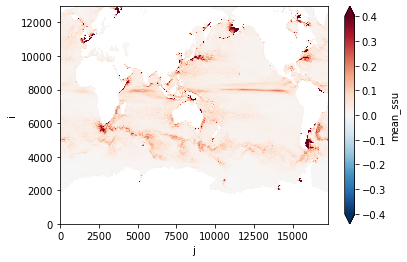

In [16]:
ds_mean.mean_ssu.plot(vmax=0.4)

In [9]:
ds_mean = llcreader.faces_dataset_to_latlon(ds)

In [20]:
ds_mean = ds.copy()

In [9]:
# Binning the Eulerian mean field (to compare with Lagrangian binned statisitcs)

dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-90., 90., dl)

N = histogram(ds.lon, ds.lat, bins=[lon, lat], dim=['i', 'j', 'face'], block_size=None)

### Mean flow : $<u>$,$<v>$

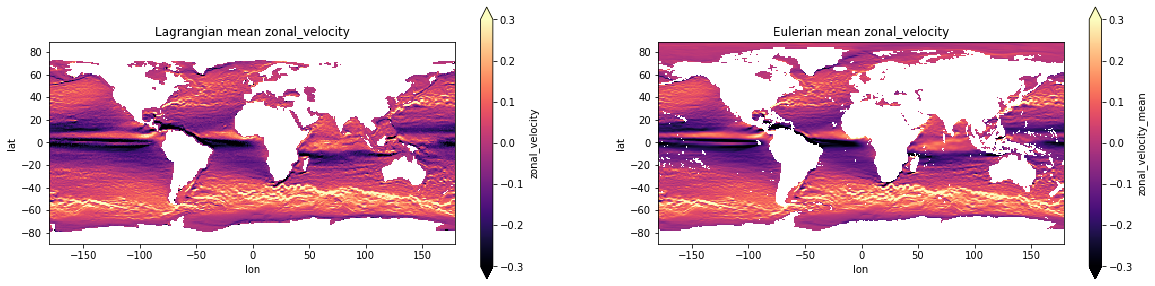

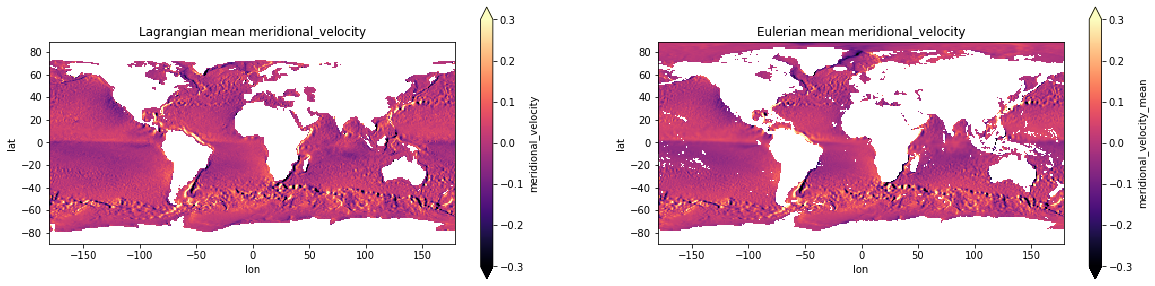

In [30]:
vmax = 0.3
colmap='magma'
for V in ["zonal_velocity","meridional_velocity"]:
    v = histogram(ds.lon, ds.lat, 
                 bins=[lon, lat], 
                 weights= (ds[V+'_mean']), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

    v_mean = (v/N).rename(V+'_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})
    fig,ax = plt.subplots(1,2,figsize=(20,5))
    ds_Lstats[V].plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[0])
    ax[0].set_aspect('equal');ax[0].set_title('Lagrangian mean %s'%str(V) )
    v_mean.plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[1])
    ax[1].set_aspect('equal');ax[1].set_title('Eulerian mean %s'%str(V) )

### Variance : $<u^2>$ and $<v^2>$

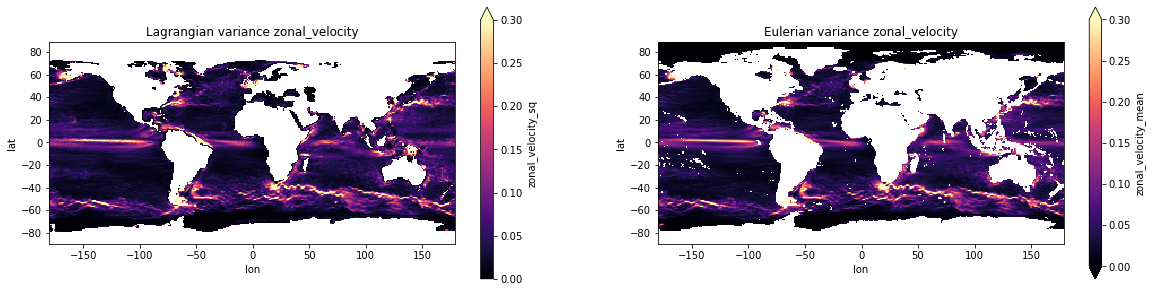

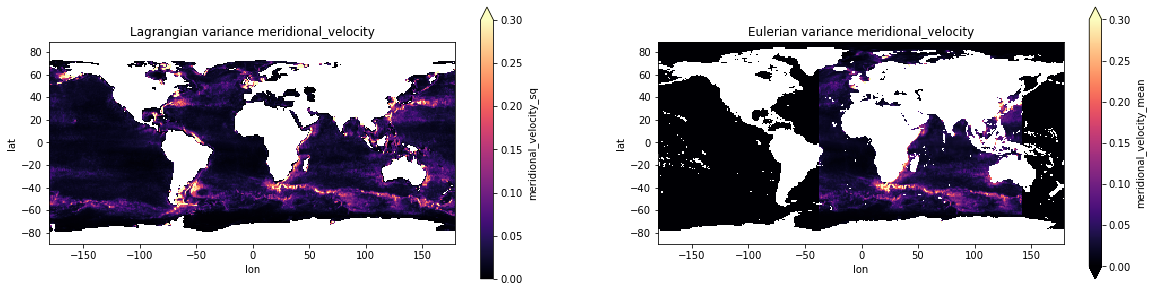

In [14]:
vmax = 0.3
colmap='magma'
for V in ["zonal_velocity","meridional_velocity"]:
    v = histogram(ds.lon, ds.lat, 
                 bins=[lon, lat], 
                 weights= (ds[V+'_mean_square']), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

    v_mean = (v/N).rename(V+'_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})
    fig,ax = plt.subplots(1,2,figsize=(20,5))
    ds_Lstats[V+'_sq'].plot(y='lat',vmax=vmax,vmin=0,cmap=colmap,ax=ax[0])
    ax[0].set_aspect('equal');ax[0].set_title('Lagrangian variance %s'%str(V) )
    v_mean.plot(y='lat',vmax=vmax,vmin=0,cmap=colmap,ax=ax[1])
    ax[1].set_aspect('equal');ax[1].set_title('Eulerian variance %s'%str(V) )

### rms : $<(u-\bar u)^2>$ and $<(v-\bar v)^2>$

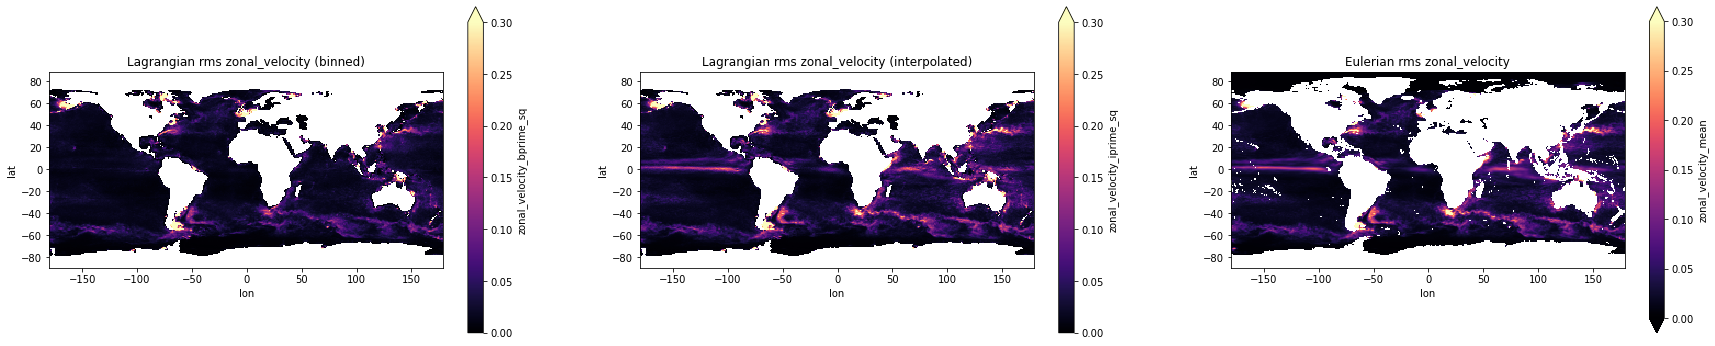

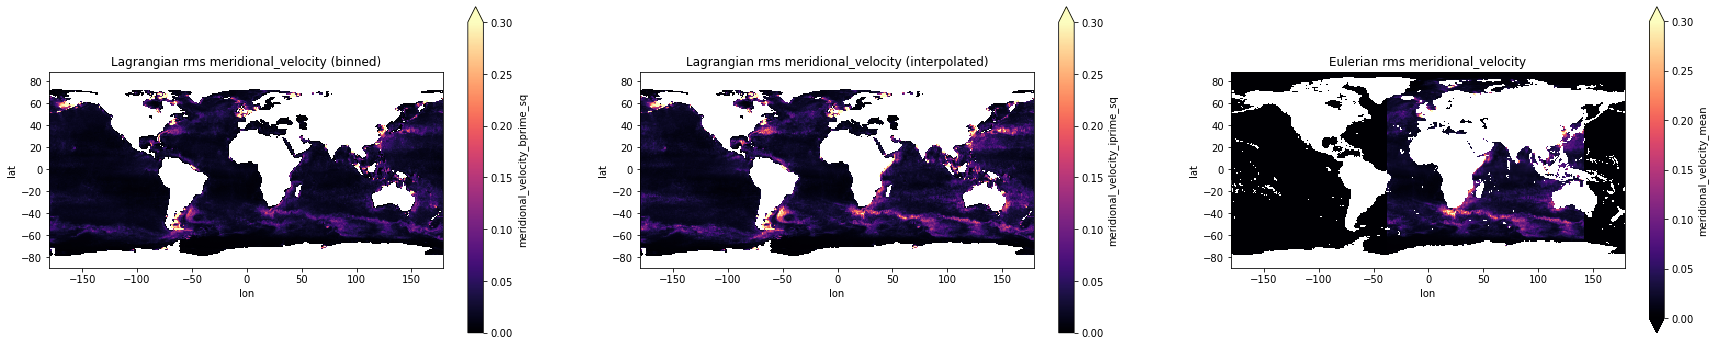

In [22]:
vmax = 0.3
colmap='magma'
for V in ["zonal_velocity","meridional_velocity"]:
    v = histogram(ds.lon, ds.lat, 
                 bins=[lon, lat], 
                 weights= (ds[V+'_prime_mean_sq']), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

    v_mean = (v/N).rename(V+'_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})
    fig,ax = plt.subplots(1,3,figsize=(30,6))
    ds_Lstats[V+'_bprime_sq'].plot(y='lat',vmax=vmax,vmin=0,cmap=colmap,ax=ax[0])
    ax[0].set_aspect('equal');ax[0].set_title('Lagrangian rms %s (binned)'%str(V) )
    ds_Lstats[V+'_iprime_sq'].plot(y='lat',vmax=vmax,vmin=0,cmap=colmap,ax=ax[1])
    ax[1].set_aspect('equal');ax[1].set_title('Lagrangian rms %s (interpolated)'%str(V) )
    v_mean.plot(y='lat',vmax=vmax,vmin=0,cmap=colmap,ax=ax[2])
    ax[2].set_aspect('equal');ax[2].set_title('Eulerian rms %s'%str(V) )

### Mean kinetic energy : $<\frac{1}{2}(\bar u ^2+\bar v ^2)>$

In [10]:
ds['mean_velocity_amplitude'] = ds.zonal_velocity_mean**2+ds.meridional_velocity_mean**2

In [11]:
MKE = histogram(ds.lon, ds.lat, 
                 bins=[lon, lat], 
                 weights= (0.5*ds.mean_velocity_amplitude), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

MKE_mean = (MKE/N).rename('MKE_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

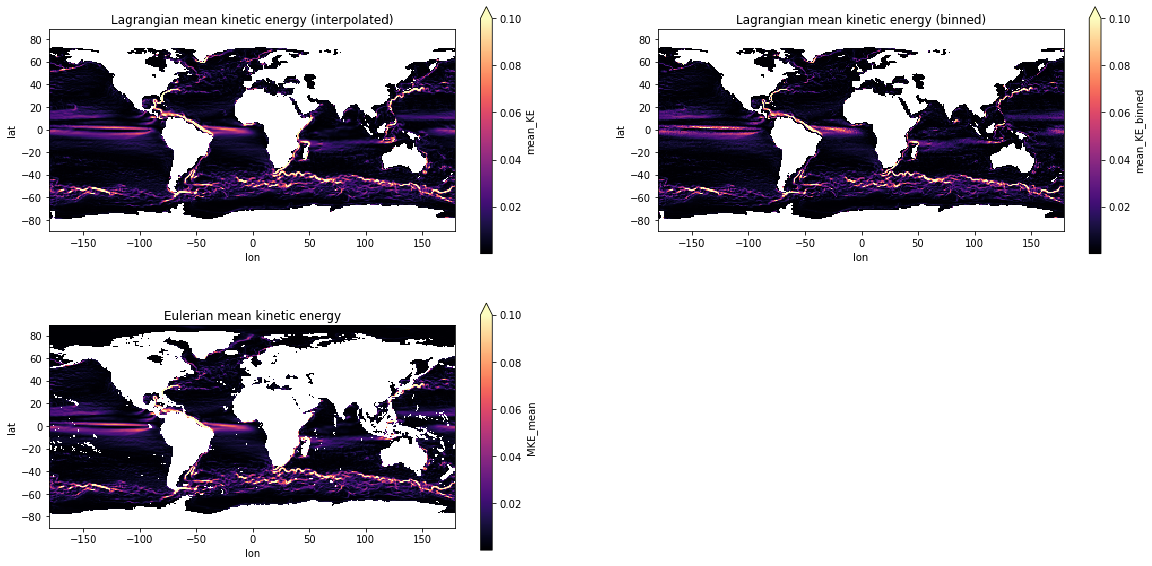

In [34]:
vmax = 0.1
colmap='magma'
fig,ax = plt.subplots(2,2,figsize=(20,10))
(0.5*ds_Lstats.mean_KE).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[0,0])
ax[0,0].set_aspect('equal');ax[0,0].set_title('Lagrangian mean kinetic energy (interpolated)')
(0.5*ds_Lstats.mean_KE_binned).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[0,1])
ax[0,1].set_aspect('equal');ax[0,1].set_title('Lagrangian mean kinetic energy (binned)')
MKE_mean.plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[1,0])
ax[1,0].set_aspect('equal');ax[1,0].set_title('Eulerian mean kinetic energy')
fig.delaxes(ax[1,1])

Text(0.5, 1.0, '$(MKE_i-MKE_b)/MKE_i$')

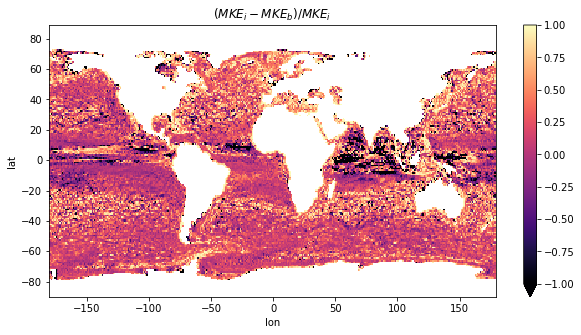

In [35]:
fig,ax = plt.subplots(figsize=(10,5))
((ds_Lstats.mean_KE-ds_Lstats.mean_KE_binned)/ds_Lstats.mean_KE).plot(y='lat',vmax=1,cmap=colmap,ax=ax)
ax.set_title(r'$(MKE_i-MKE_b)/MKE_i$')

Text(0.5, 1.0, '$MKE_b/MKE_i$')

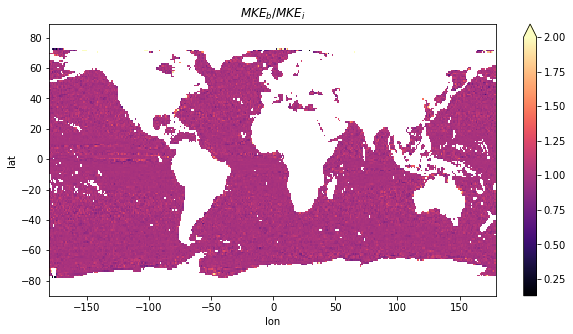

In [33]:
fig,ax = plt.subplots(figsize=(10,5))
((MKE_mean)/(0.5*ds_Lstats.mean_KE)).plot(y='lat',vmax=2,cmap=colmap,ax=ax)
ax.set_title(r'$MKE_b/MKE_i$')

Text(0.5, 1.0, '$(MKE_i-MKE)/MKE_i$')

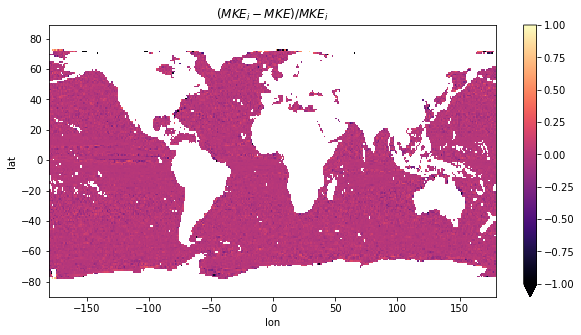

In [36]:
fig,ax = plt.subplots(figsize=(10,5))
((0.5*ds_Lstats.mean_KE-MKE_mean)/(0.5*ds_Lstats.mean_KE)).plot(y='lat',vmax=1,cmap=colmap,ax=ax)
ax.set_title(r'$(MKE_i-MKE)/MKE_i$')

### Total kinetic energy : $<\frac{1}{2}(u^2+v^2)>$

In [ ]:
KE = histogram(ds.lon, ds.lat, 
                 bins=[lon, lat], 
                 weights= (0.5*ds.velocity_amplitude), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

KE_mean = (MKE/N).rename('MKE_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

Text(0.5, 1.0, 'Lagrangian total kinetic energy')

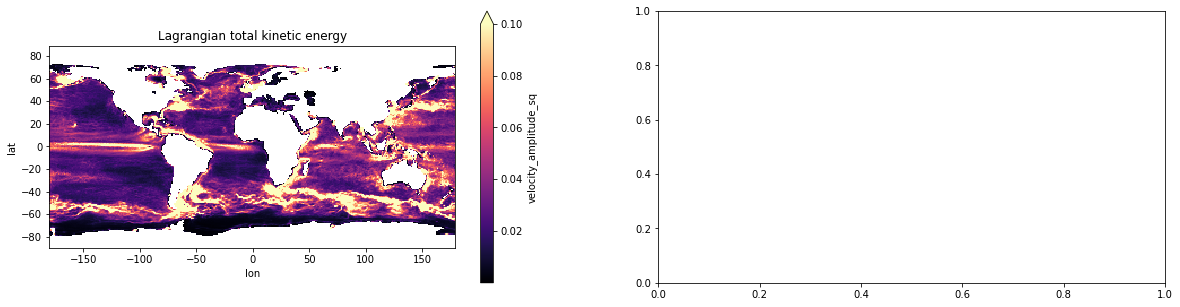

In [28]:
vmax = 0.1
colmap='magma'
fig,ax = plt.subplots(1,2,figsize=(20,5))
(0.5*ds_Lstats.velocity_amplitude_sq).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[0])
ax[0].set_aspect('equal');ax[0].set_title('Lagrangian total kinetic energy')
#MKE_mean.plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[1,0])
#ax[1,0].set_aspect('equal');ax[1,0].set_title('Eulerian mean kinetic energy')
#fig.delaxes(ax[1,1])

### Eddy kinetic energy : $<\frac{1}{2}(u'^2+v'^2)>$
In Lagrangian perspective, $u'$ can be defined by two methods:

1) Binning, $\bar u_b$ : the velocity aloong drifters trajectory is binned and averaged over time and bins
2) Interpolation of Eulerian field, $\bar u_i$ : the Eulerian field is computed on the model grid and then interpolated over every drifters trajectory

The eddy kinetic energy can be computed in two differents ways:

1) $u-\bar u_b$
2) $u-\bar u_i$

In [ ]:
EKE = histogram(ds.lon, ds.lat, 
                 bins=[lon, lat], 
                 weights= (0.5*ds.zonal_velocity), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

EKE_mean = (MKE/N).rename('MKE_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

Text(0.5, 1.0, 'Lagrangian eddy kinetic energy (binned)')

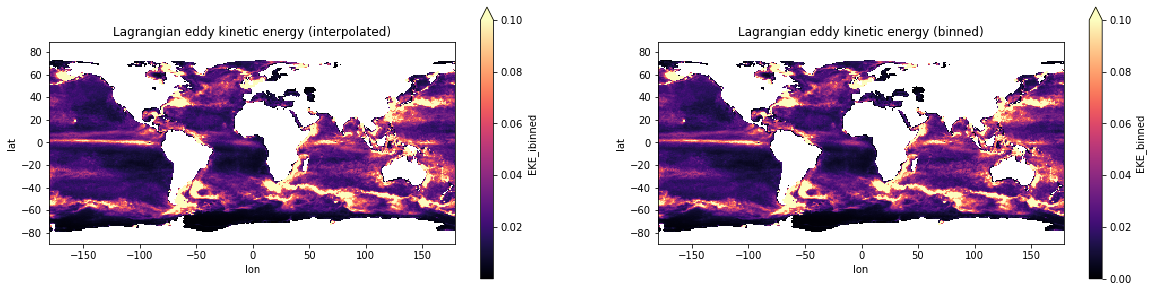

In [15]:
vmax = 0.1
colmap='magma'
fig,ax = plt.subplots(1,2,figsize=(20,5))
(0.5*ds_Lstats.EKE_ibinned).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[0])
ax[0].set_aspect('equal');ax[0].set_title('Lagrangian eddy kinetic energy (interpolated)')
(0.5*ds_Lstats.EKE_binned).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[1])
ax[1].set_aspect('equal');ax[1].set_title('Lagrangian eddy kinetic energy (binned)')
#MKE_mean.plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[1,0])
#ax[1,0].set_aspect('equal');ax[1,0].set_title('Eulerian mean kinetic energy')
#ig.delaxes(ax[1,1])

Text(0.5, 1.0, '$(EKE_i-EKE_b)/EKE_i$')

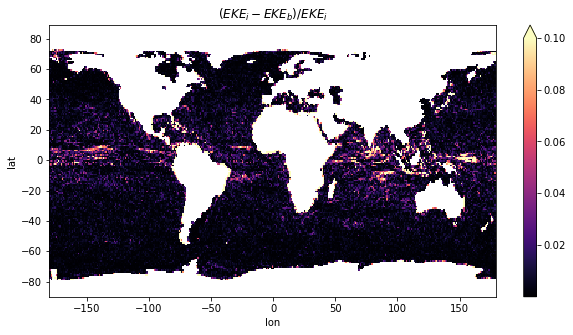

In [21]:
fig,ax = plt.subplots(figsize=(10,5))
((ds_Lstats.EKE_ibinned-ds_Lstats.EKE_binned)/ds_Lstats.EKE_ibinned).plot(y='lat',vmax=0.1,cmap=colmap,ax=ax)
ax.set_title(r'$(EKE_i-EKE_b)/EKE_i$')

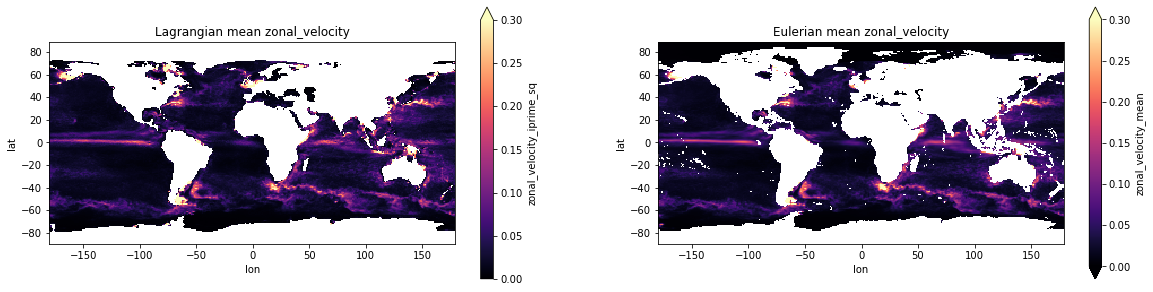

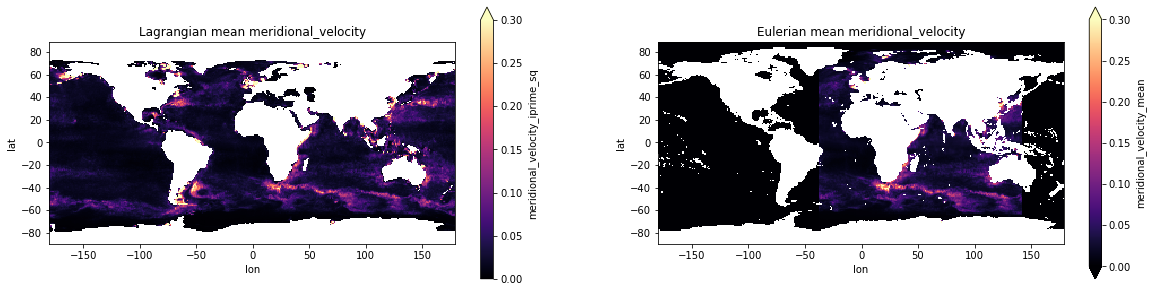

In [22]:
vmax = 0.3
colmap='magma'
for V in ["zonal_velocity","meridional_velocity"]:
    v = histogram(ds_mean.lon, ds_mean.lat, 
                 bins=[lon, lat], 
                 weights= (ds_mean[V+'_prime_mean_sq']), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

    v_mean = (v/N).rename(V+'_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})
    fig,ax = plt.subplots(1,2,figsize=(20,5))
    ds_Lstats[V+'_iprime_sq'].plot(y='lat',vmax=vmax,vmin=0,cmap=colmap,ax=ax[0])
    ax[0].set_aspect('equal');ax[0].set_title('Lagrangian mean %s'%str(V) )
    v_mean.plot(y='lat',vmax=vmax,vmin=0,cmap=colmap,ax=ax[1])
    ax[1].set_aspect('equal');ax[1].set_title('Eulerian mean %s'%str(V) )

In [9]:
cluster.close()